In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys

from collections import defaultdict
from time import time
from os import makedirs
from os.path import join, isdir
from glob import glob
from keras.callbacks import TensorBoard

sys.path.append('scripts')
from model_helpers import *
from data_helpers import *
from train_helpers import *

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
IMGS_PATH = "D:/Alpha/anomaly-detection-image-completion/data"
OUT_PATH = 'saved/logs'
if not isdir(OUT_PATH):
    makedirs(OUT_PATH)

# Hyperparameters

In [3]:
patch_size = (128, 128)
center_size = (32, 32)
num_train_test = num_test_test = 10
batch_size = 128
num_epochs = 500
model_width = 2

# Load data

In [4]:
# print(glob(join("D:\Alpha\anomaly-detection-image-completion\data", '*png')))
print(glob(join("D:/Alpha/anomaly-detection-image-completion/data","*png")))

['D:/Alpha/anomaly-detection-image-completion/data\\000.png', 'D:/Alpha/anomaly-detection-image-completion/data\\001.png', 'D:/Alpha/anomaly-detection-image-completion/data\\002.png', 'D:/Alpha/anomaly-detection-image-completion/data\\003.png', 'D:/Alpha/anomaly-detection-image-completion/data\\004.png', 'D:/Alpha/anomaly-detection-image-completion/data\\005.png', 'D:/Alpha/anomaly-detection-image-completion/data\\006.png', 'D:/Alpha/anomaly-detection-image-completion/data\\007.png', 'D:/Alpha/anomaly-detection-image-completion/data\\008.png', 'D:/Alpha/anomaly-detection-image-completion/data\\009.png', 'D:/Alpha/anomaly-detection-image-completion/data\\010.png', 'D:/Alpha/anomaly-detection-image-completion/data\\011.png', 'D:/Alpha/anomaly-detection-image-completion/data\\012.png', 'D:/Alpha/anomaly-detection-image-completion/data\\013.png', 'D:/Alpha/anomaly-detection-image-completion/data\\014.png', 'D:/Alpha/anomaly-detection-image-completion/data\\015.png', 'D:/Alpha/anomaly-detec

In [5]:
# files = np.random.choice(glob(join(IMGS_PATH, '*png')), 10000, replace=False)
files = np.random.choice(glob(join(IMGS_PATH, '*png')), 10000, replace=True)
train_files = files[:-(num_train_test + num_test_test)]
train_test_files, test_test_files = files[-(num_train_test + num_test_test):-num_test_test], files[-num_test_test:]
fake_files = glob('D:/Alpha/anomaly-detection-image-completion/data/fake_files/*png')

In [6]:
imgss = defaultdict(list)
start = time()
for dataset, files in zip(['train', 'train_test', 'test_test', 'fake'], 
                          [train_files, train_test_files, test_test_files, fake_files]):
    for i, f in enumerate(files):
        imgss[dataset].append(cv2.imread(f, 0))
        if i % 1000 == 0 and i != 0:
            end = time()
            print('Processing dataset {}: {:.0f} sec - ETA: {:.0f} sec'.format(
                dataset, end-start, ((end-start) / (i + 1)) * (len(files) - i)))

Processing dataset train: 27 sec - ETA: 239 sec
Processing dataset train: 45 sec - ETA: 181 sec
Processing dataset train: 64 sec - ETA: 149 sec
Processing dataset train: 84 sec - ETA: 126 sec
Processing dataset train: 124 sec - ETA: 123 sec
Processing dataset train: 172 sec - ETA: 114 sec
Processing dataset train: 208 sec - ETA: 89 sec
Processing dataset train: 253 sec - ETA: 63 sec
Processing dataset train: 287 sec - ETA: 31 sec


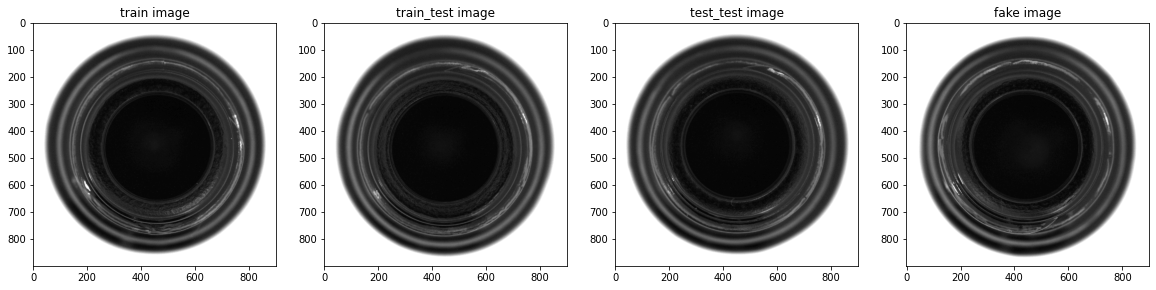

In [7]:
fig, ax = plt.subplots(1, len(imgss.keys()), figsize=(20, 30))
for i, (dataset, imgs) in enumerate(imgss.items()):
    ax[i].imshow(imgs[0], 'gray')
    ax[i].set_title('{} image'.format(dataset))

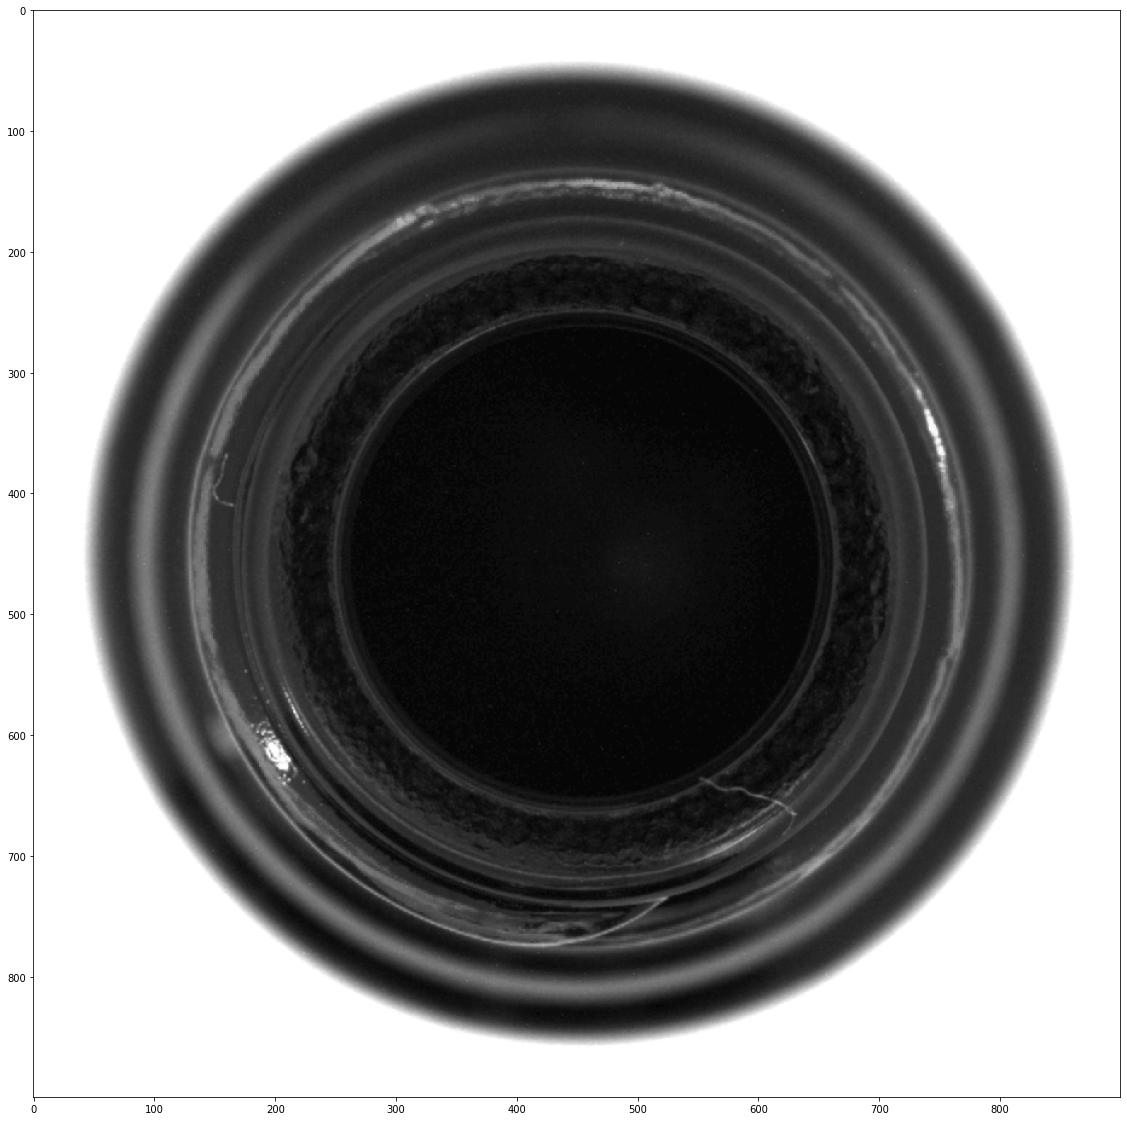

In [8]:
plt.figure(figsize=(30, 20))
plt.imshow(imgss['fake'][1], 'gray')

## Square images and resize to same size

In [9]:
for dataset, imgs in imgss.items():
    res_imgs = [img[:min(img.shape), :min(img.shape)] for img in imgs] 
    min_size = np.min([img.shape[0] for img in res_imgs])

    res_imgs = [cv2.resize(img, (min_size, min_size), interpolation=cv2.INTER_CUBIC) for img in res_imgs]
    imgss[dataset] = np.expand_dims(res_imgs, axis=3)

## Create training generator and evaluation images

In [10]:
train_generator = DataGenerator(imgss['train'], patch_size, center_size, batch_size=batch_size, shuffle=True)

In [12]:
x_test = []
for patches in patchess.values():
    x_test.extend(patches)
x_test = np.array(x_test)

In [11]:
mask = create_center_mask(patch_size, center_size)
patchess = defaultdict(list)
for i, (dataset, imgs) in enumerate(imgss.items()):
    if dataset != 'train':
        for j, img in enumerate(imgs):
            patchess[dataset].append(prepare_patch(img, patch_size, mask, i + j))

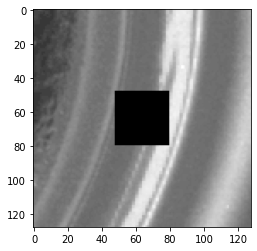

In [13]:
plt.imshow(np.squeeze(patchess['fake'][3]), 'gray')

# Create model

In [14]:
model = create_anomaly_cnn(model_width=model_width)

In [15]:
model.patch_size = patch_size
model.center_size = center_size
model.batch_size = batch_size
model.num_epochs = num_epochs
model.model_width = model_width

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 130, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1664      
                                                                 
 elu (ELU)                   (None, 126, 126, 64)      0         
                                                                 
 lambda_1 (Lambda)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 128)     73856     
                                                                 
 elu_1 (ELU)                 (None, 126, 126, 128)     0     

In [17]:
model.compile(optimizer='adam', loss=reconstruction_loss(patch_size, mask=mask), metrics=['accuracy'])

In [22]:
images_callback = TensorBoardImages(OUT_PATH, patchess, vis_every=1)
checkpoint_callback = CustomModelCheckpoint(OUT_PATH, save_weights_only=False)
losses_callback = TensorBoard(log_dir=OUT_PATH, batch_size=batch_size)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
history_dict = model.fit_generator(train_generator, 
                                   validation_data=(x_test, x_test),
                                   epochs=2, 
                                   verbose=1, 
                                   callbacks=[images_callback, checkpoint_callback, losses_callback], 
                                   callbacks=[checkpoint_callback, losses_callback], 
                                   workers=10, 
                                   use_multiprocessing=True, 
                                   shuffle=False, 
                                   initial_epoch=0)